<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_with_DeepSMOTE_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 769M/786M [00:06<00:00, 139MB/s]
100% 786M/786M [00:06<00:00, 125MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import collections

def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

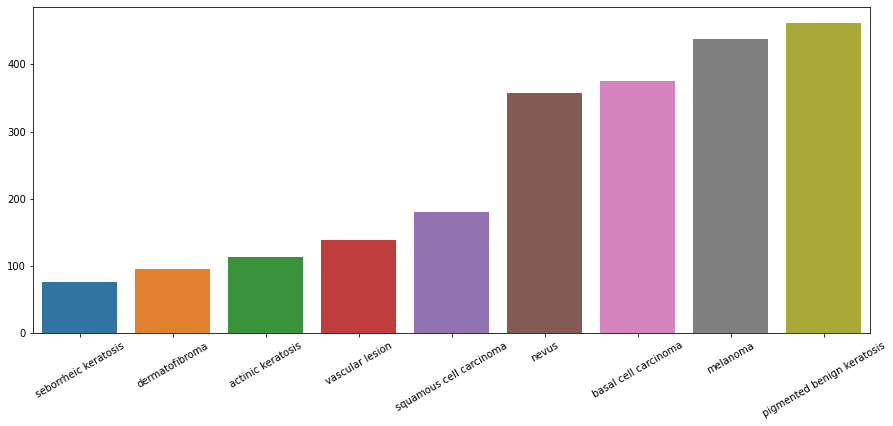

In [ ]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

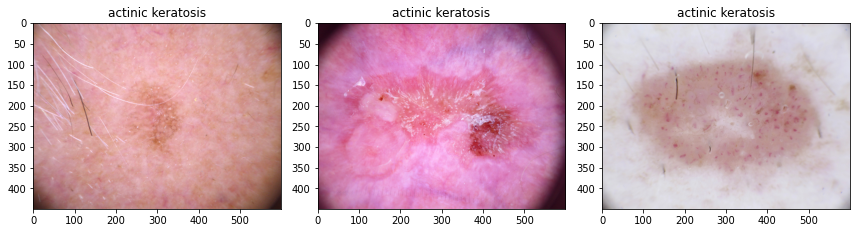

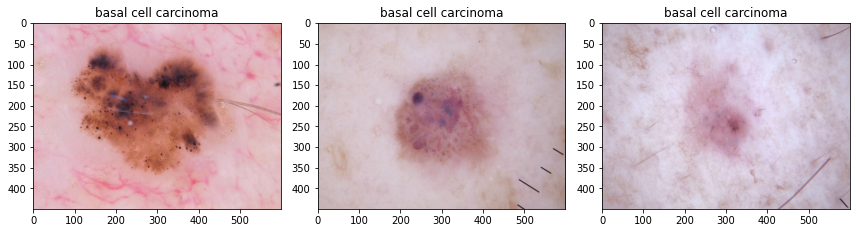

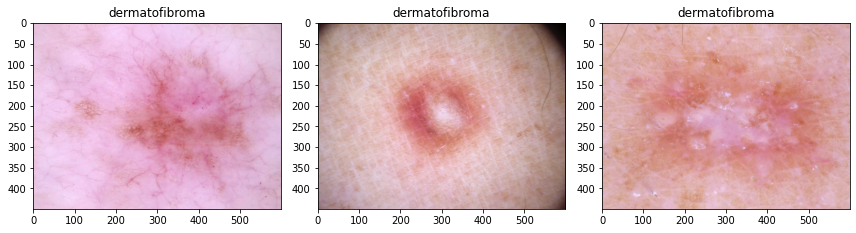

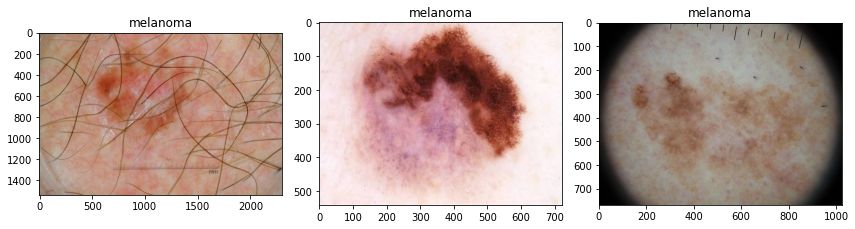

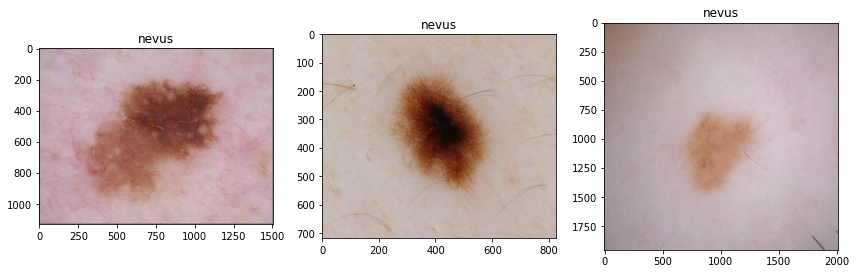

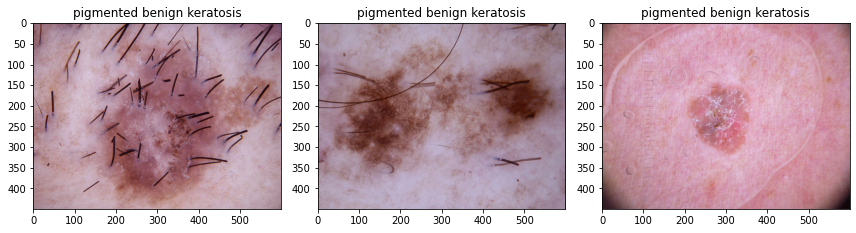

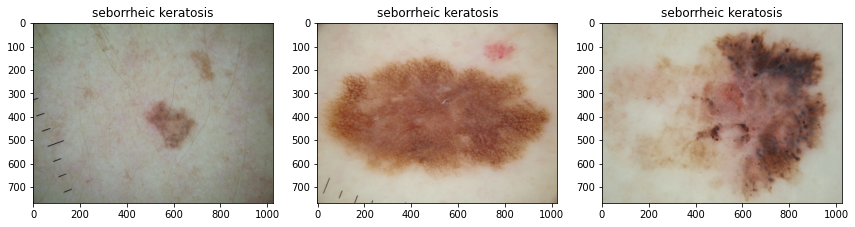

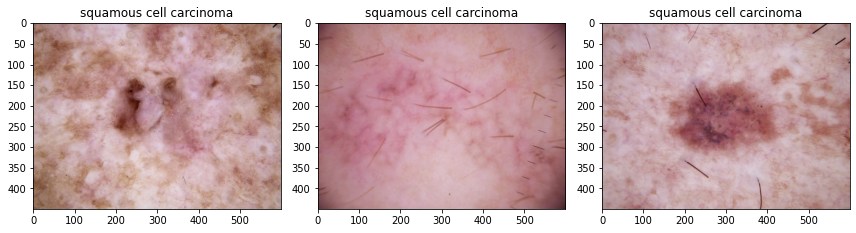

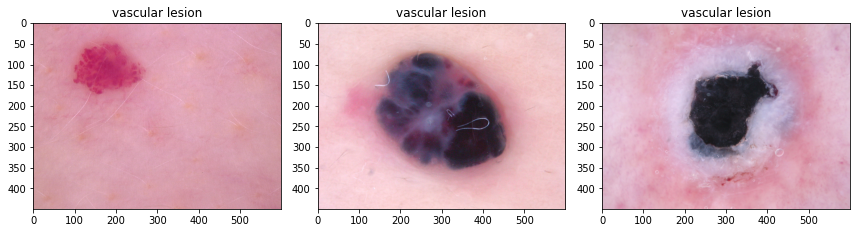

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

In [4]:
y = df['Labels']
#X = df.drop('Labels', 1)

In [5]:
# input image size
IMAGE_W = 32
IMAGE_H = 32
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X = []
for img in df['FilePaths']:
    img_arr = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(img_arr)
    X.append(img_arr)
      
print(np.array(X).shape)

(2239, 32, 32, 3)


In [7]:
from sklearn import preprocessing
X = np.array(X)
y = np.array(y.values)
y = y.reshape(-1,1)
label_encoder = preprocessing.LabelEncoder()
y= label_encoder.fit_transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
print('X shape: ',X.shape)
print('y shape: ',y.shape)

X shape:  (2239, 32, 32, 3)
y shape:  (2239,)


#Dataset Balancer with DeepSMOTE

In [11]:
#optional
X=X_train
y=y_train

In [12]:
from numpy import moveaxis
dec_x = moveaxis(X, 3, 1)
dec_x = dec_x.astype('float32') / 255.
#dec_x = X_train 
dec_y = y

In [29]:
print("Label count before oversampling")
counter = collections.Counter(dec_y)
print(counter)

Label count before oversampling
Counter({5: 416, 3: 394, 1: 338, 4: 321, 7: 163, 8: 125, 0: 103, 2: 86, 6: 69})


In [31]:
counter = sorted(counter.items())
counter = [value for _, value in counter]
counter

[103, 338, 86, 394, 321, 416, 69, 163, 125]

In [32]:
counter

[103, 338, 86, 394, 321, 416, 69, 163, 125]

In [ ]:
dec_x[:10]

In [14]:
dec_y

array([7, 6, 5, ..., 1, 4, 5])

#Preparing Encode/Decoder Arch

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.neighbors import NearestNeighbors
import time
import os

print(torch.version.cuda) #10.1
t3 = time.time()
##############################################################################
"""args for AE"""

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 

args['n_z'] = 600 #300     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 100       # how many epochs to run for
args['batch_size'] = 15   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['dataset'] = 'mnist'  #'fmnist' # specify which dataset to use


##############################################################################

11.3


In [16]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),
            
            #3d and 32 by 32
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True) )#,
            #nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False))
            #nn.Conv2d(self.dim_h * 8, 1, 4, 1, 0, bias=False))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**4 * 8 * 8),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 16, self.dim_h * 8, 4),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 3, 4, stride=2, padding=2),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**4, 8, 8)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

##Training the Encoder/Decoder Framework

In [17]:
batch_size = args['batch_size']
encoder = Encoder(args)
decoder = Decoder(args)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
decoder = decoder.to(device)
encoder = encoder.to(device)

train_on_gpu = torch.cuda.is_available()

#decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

num_workers = 0

#torch.Tensor returns float so if want long then use torch.tensor
tensor_x = torch.Tensor(dec_x)
tensor_y = torch.tensor(dec_y,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, 
    batch_size=batch_size,shuffle=True,num_workers=num_workers)

#classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8')

best_loss = np.inf

t0 = time.time()
if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    for epoch in range(args['epochs']):
        train_loss = 0.0
        tmse_loss = 0.0
        tdiscr_loss = 0.0
        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
    
        for images,labs in train_loader:
        
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            images, labs = images.to(device), labs.to(device)
            labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
            # run images
            z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
        
            x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
            mse = criterion(x_hat,images)
                    
            resx = []
            resy = []
        
            tc = np.random.choice(9,1)
            #tc = 9
            xbeg = dec_x[dec_y == tc]
            ybeg = dec_y[dec_y == tc] 
            xlen = len(xbeg)
            nsamp = min(xlen, 100)
            ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
            xclass = xbeg[ind]
            yclass = ybeg[ind]
        
            xclen = len(xclass)
            xcminus = np.arange(1,xclen)
            
            xcplus = np.append(xcminus,0)
            xcnew = (xclass[[xcplus],:])
            xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
        
            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
        
            #encode xclass to feature space
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
        
            xclass = xclass.detach().cpu().numpy()
        
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
        
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            
            ximg = decoder(xc_enc)
            
            mse2 = criterion(ximg,xcnew)
        
            comb_loss = mse2 + mse
            comb_loss.backward()
        
            enc_optim.step()
            dec_optim.step()
        
            train_loss += comb_loss.item()*images.size(0)
            tmse_loss += mse.item()*images.size(0)
            tdiscr_loss += mse2.item()*images.size(0)
        
              
        # print avg training statistics 
            
            
#        tensor_image = x_hat[0]
#        tensor_image = tensor_image.detach()
        
#        import torchvision.transforms.functional as F
#        tensor_image = F.to_pil_image(tensor_image)

#        plt.imshow(tensor_image)
#        plt.show()

        train_loss = train_loss/len(train_loader)
        tmse_loss = tmse_loss/len(train_loader)
        tdiscr_loss = tdiscr_loss/len(train_loader)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                train_loss,tmse_loss,tdiscr_loss))
        
    
    
        #store the best encoder and decoder models
        #here, /crs5 is a reference to 5 way cross validation, but is not
        #necessary for illustration purposes
#        if train_loss < best_loss:
#            print('Saving..')
#            path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_enc.pth'
#            path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_dec.pth'
          
#            torch.save(encoder.state_dict(), path_enc)
#            torch.save(decoder.state_dict(), path_dec)
    
#            best_loss = train_loss
    
    
    #in addition, store the final model (may not be the best) for
    #informational purposes
#    path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_enc.pth'
#    path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_dec.pth'
#    print(path_enc)
#    print(path_dec)
#    torch.save(encoder.state_dict(), path_enc)
#    torch.save(decoder.state_dict(), path_dec)
    print()
          
t1 = time.time()
print('total time(min): {:.2f}'.format((t1 - t0)/60))             


cuda
Epoch: 0 	Train Loss: 1.821430 	mse loss: 0.927056 	mse2 loss: 0.894374
Epoch: 1 	Train Loss: 0.458891 	mse loss: 0.239399 	mse2 loss: 0.219492
Epoch: 2 	Train Loss: 0.328928 	mse loss: 0.173923 	mse2 loss: 0.155006
Epoch: 3 	Train Loss: 0.270257 	mse loss: 0.142687 	mse2 loss: 0.127570
Epoch: 4 	Train Loss: 0.214651 	mse loss: 0.111696 	mse2 loss: 0.102955
Epoch: 5 	Train Loss: 0.189421 	mse loss: 0.101430 	mse2 loss: 0.087992
Epoch: 6 	Train Loss: 0.178377 	mse loss: 0.094393 	mse2 loss: 0.083984
Epoch: 7 	Train Loss: 0.165955 	mse loss: 0.087611 	mse2 loss: 0.078343
Epoch: 8 	Train Loss: 0.156582 	mse loss: 0.082519 	mse2 loss: 0.074063
Epoch: 9 	Train Loss: 0.149811 	mse loss: 0.079395 	mse2 loss: 0.070416
Epoch: 10 	Train Loss: 0.137093 	mse loss: 0.073658 	mse2 loss: 0.063435
Epoch: 11 	Train Loss: 0.134414 	mse loss: 0.073357 	mse2 loss: 0.061057
Epoch: 12 	Train Loss: 0.129318 	mse loss: 0.069284 	mse2 loss: 0.060034
Epoch: 13 	Train Loss: 0.125299 	mse loss: 0.067627 	mse

##Start oversample using trained Encoder/Decoder and SMOTE

In [33]:
import torch
np.printoptions(precision=5,suppress=True)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/'

encf = []
decf = []
for p in range(1):
    enc = modpth + '/bst_enc.pth'
    dec = modpth + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)

for m in range(1):
    print('decy ',dec_y.shape)
    print('train imgs shape ',dec_x.shape) #(45000,3,32,32)
#    classes = ('5', '3', '1', '4', '7', '8', '0', '2', '6')
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

#    encoder = Encoder(args)
#    encoder.load_state_dict(torch.load(path_enc), strict=False)
#    encoder = encoder.to(device)

#    decoder = Decoder(args)
#    decoder.load_state_dict(torch.load(path_dec), strict=False)
#    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    imbal = counter#[114, 376, 95, 438, 357, 462, 77, 181, 139]

    resx = []
    resy = []

    for i in [0,1,2,3,4,6,7,8]: #skip class 5 since it's max class
        torch.cuda.empty_cache()

        xclass, yclass = biased_get_class(i)
        print(xclass.shape) #(500, 3, 32, 32)
        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
        print(xclass.shape) #torch.Size([500, 600])
            
        xclass = xclass.detach().cpu().numpy()
        n = imbal[5] - imbal[i]
        xsamp, ysamp = G_SM(xclass,yclass,n,i)
        print(xsamp.shape) #(4500, 600)
        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
        print(ysamp.shape) #4500   
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
        print(ximn.shape) 
        print(ximn.shape) 
        resx.append(ximn)
        resy.append(ysamp)
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
    print(resx1.shape) #(34720, 3, 32, 32)
    print(resy1.shape) #(34720,)

    resx1 = resx1.reshape(resx1.shape[0],-1)
    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = dec_x.reshape(dec_x.shape[0],-1)
    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,dec_y))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)

#    ifile = '/content/drive/MyDrive/PHD/Datasets/Skin Cancer/DeepSMOTE/trn_img_f/2_trn_img.txt'
#    np.savetxt(ifile, combx)
    
#    lfile = '/content/drive/MyDrive/PHD/Datasets/Skin Cancer/DeepSMOTE/trn_lab_f/2_trn_lab.txt'
#    np.savetxt(lfile,comby) 
    print()

decy  (2015,)
train imgs shape  (2015, 3, 32, 32)
(103, 3, 32, 32)
0
torch.Size([103, 600])
(313, 600)
313
(313,)
(313, 3, 32, 32)
(313, 3, 32, 32)
(338, 3, 32, 32)
1
torch.Size([338, 600])
(78, 600)
78
(78,)
(78, 3, 32, 32)
(78, 3, 32, 32)
(86, 3, 32, 32)
2
torch.Size([86, 600])
(330, 600)
330
(330,)
(330, 3, 32, 32)
(330, 3, 32, 32)
(394, 3, 32, 32)
3
torch.Size([394, 600])
(22, 600)
22
(22,)
(22, 3, 32, 32)
(22, 3, 32, 32)
(321, 3, 32, 32)
4
torch.Size([321, 600])
(95, 600)
95
(95,)
(95, 3, 32, 32)
(95, 3, 32, 32)
(69, 3, 32, 32)
6
torch.Size([69, 600])
(347, 600)
347
(347,)
(347, 3, 32, 32)
(347, 3, 32, 32)
(163, 3, 32, 32)
7
torch.Size([163, 600])
(253, 600)
253
(253,)
(253, 3, 32, 32)
(253, 3, 32, 32)
(125, 3, 32, 32)
8
torch.Size([125, 600])
(291, 600)
291
(291,)
(291, 3, 32, 32)
(291, 3, 32, 32)
(1729, 3, 32, 32)
(1729,)
(1729, 3072)
decx1  (2015, 3072)
(3744, 3072)
(3744,)



In [34]:
X = combx.reshape(-1, 3, IMAGE_W, IMAGE_H)
X = moveaxis(X, 1, 3)
X = (X * 255).astype('int')
y = comby.reshape(-1,1)

In [35]:
print(collections.Counter(comby))
print('X shape: ',X.shape)
print('y shape: ',y.shape)

Counter({0: 416, 1: 416, 2: 416, 3: 416, 4: 416, 6: 416, 7: 416, 8: 416, 5: 416})
X shape:  (3744, 32, 32, 3)
y shape:  (3744, 1)


##Prepare data for training

Split dataset to train and val

In [9]:
from sklearn.model_selection import train_test_split

In [ ]:
# stratified train and remaining (20%) datasets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_rem.shape)

Train Data:  (3326, 32, 32, 3)
Remaining Data:  (832, 32, 32, 3)


In [ ]:
# stratified test and val (50%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Validation Data: ', X_val.shape)
print('Test Data: ', X_test.shape)

Validation Data:  (416, 32, 32, 3)
Test Data:  (416, 32, 32, 3)


In [10]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [36]:
#optional
# stratified train and val (12%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3294, 32, 32, 3)
Val Data:  (450, 32, 32, 3)


In [37]:
X_train

array([[[[168, 122, 125],
         [173, 132, 133],
         [168, 125, 127],
         ...,
         [148, 107, 108],
         [156, 112, 115],
         [136,  93,  89]],

        [[168, 128, 129],
         [180, 140, 140],
         [171, 125, 127],
         ...,
         [153, 115, 114],
         [148, 104, 104],
         [145,  99, 101]],

        [[179, 139, 144],
         [181, 144, 149],
         [182, 141, 145],
         ...,
         [152, 113, 118],
         [138,  94,  98],
         [151, 109, 109]],

        ...,

        [[176, 129, 124],
         [186, 150, 148],
         [195, 159, 162],
         ...,
         [132,  84,  86],
         [117,  69,  67],
         [109,  61,  58]],

        [[180, 139, 139],
         [190, 152, 154],
         [189, 153, 159],
         ...,
         [139,  87,  84],
         [122,  70,  69],
         [128,  76,  77]],

        [[178, 138, 137],
         [185, 147, 148],
         [182, 147, 148],
         ...,
         [138,  88,  88],
        

# ResNet Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [38]:
# count of epchos
EPOCHS = 100
# number of samples/images per iteration
BATCH_SIZE = 32

In [39]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
import numpy as np

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
# create the base pre-trained model
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)
#predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
hst = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val))

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/100
103/103 [==============================] - 7s 25ms/step - loss: 2.9641 - accuracy: 0.3628 - val_loss: 1.2793 - val_accuracy: 0.5600
Epoch 2/100
103/103 [==============================] - 2s 18ms/step - loss: 1.4193 - accuracy: 0.5194 - val_loss: 1.1427 - val_accuracy: 0.6089
Epoch 3/100
103/103 [==============================] - 2s 20ms/step - loss: 1.2172 - accuracy: 0.5713 - val_loss: 1.1009 - val_accuracy: 0.6044
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 1.1254 - accuracy: 0.6084 - val_loss: 1.0215 - val_accuracy: 0.6533
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 1.0332 - accuracy: 0.6263 - val_loss: 0.9893 - val_accuracy: 0.6511
Epoch 6/100
103/103 [==============================] - 1s 13ms/step - loss: 0.9560 - accuracy: 0.6576 - val_loss: 0.9845 - val_accuracy: 0.6667
Epoch 7/100
103/103 [==============================] - 1s 13ms/step - l

In [ ]:
#Saving a Keras model:
model.save('/content/drive/MyDrive/PHD')

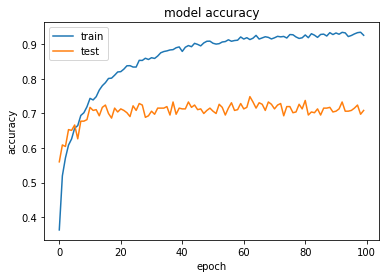

In [40]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst2 = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/100
103/103 [==============================] - 5s 22ms/step - loss: 0.2867 - accuracy: 0.9174 - val_loss: 1.6858 - val_accuracy: 0.7267
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 0.2179 - accuracy: 0.9317 - val_loss: 1.7564 - val_accuracy: 0.7333
Epoch 3/100
103/103 [==============================] - 2s 18ms/step - loss: 0.1984 - accuracy: 0.9277 - val_loss: 1.7638 - val_accuracy: 0.7267
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.1760 - accuracy: 0.9344 - val_loss: 1.7726 - val_accuracy: 0.7267
Epoch 5/100
103/103 [==============================] - 1s 13ms/step - loss: 0.1592 - accuracy: 0.9372 - val_loss: 1.7469 - val_accuracy: 0.7333
Epoch 6/100
103/103 [==============================] - 1s 14ms/step - loss: 0.1554 - accuracy: 0.9381 - val_loss: 1.7261 - val_accuracy: 0.7333
Epoch 7/100
103/103 [==============================] - 1s 13ms/step - loss: 0.1611 - accuracy: 0.9396 - val_loss: 1.7313 - val_accuracy:

In [ ]:
#Saving a Keras model:
model.save('/content/drive/MyDrive/PHD/fine-tune')

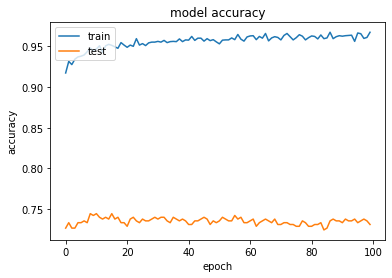

In [42]:
# summarize history for accuracy
plt.plot(hst2.history['accuracy'])
plt.plot(hst2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load test data

In [ ]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [ ]:
X_test.head(3)

In [ ]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Preprocess test image

In [ ]:
X_test_arr = []
for img in X_test['FilePaths']:
    loaded_img = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(loaded_img)
    X_test_arr.append(img_arr)
    
print(np.array(X_test_arr).shape)  
y_test = X_test['Labels']
X_test = X_test_arr

y_test = np.array(y_test.values)
X_test = np.array(X_test)

In [ ]:
y_test = y_test.reshape(-1,1)
y_test= label_encoder.fit_transform(y_test)
y_test

In [ ]:
y_test = y_test.reshape(-1,1)

Evaluate model againts test data

In [43]:
res = model.evaluate(X_test,y_test)

7/7 [==============================] - 1s 11ms/step - loss: 3.2737 - accuracy: 0.4955


The accuracy

In [44]:
# accuracy
print(f'Train Accuracy: {hst2.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst2.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst2.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst2.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 96.75
Val Accuracy: 73.11
Test Accuracy: 49.55
Train Loss: 7.77
Val Loss: 164.64
Test Loss: 327.37


Calculate y_pred

In [45]:
# predicted labels
Y_pred = model.predict(X_train)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)
# predicted labels
Y_pred2 = model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

Y_pred (3294, 9)
y_pred 3294
Y_pred2 (224, 9)
y_pred2 224


Calculate y_true

In [46]:
# true labels
#y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
#class_labels = list(X_test.class_indices.keys())
print("labels", len(y_train))

y_pred 3294
labels 3294


The confusion metric

In [47]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)

print(cf_matrix)
cf_matrix2 = confusion_matrix(y_test, y_pred2)
print(cf_matrix2)

[[349   0   0   0  17   0   0   0   0]
 [  0 366   0   0   0   0   0   0   0]
 [  0   0 366   0   0   0   0   0   0]
 [  0   0   0 326   0   0  40   0   0]
 [ 25   0   0   0 341   0   0   0   0]
 [  0   0   0   0   0 366   0   0   0]
 [  0   0   0  12   0   0 354   0   0]
 [  0   0   0   0   0   0   0 366   0]
 [  0   0   0   0   0   0   0   0 366]]
[[ 2  0  0  0  8  1  0  0  0]
 [ 1 16  1  4  1  5  3  4  3]
 [ 0  1  3  0  0  2  0  1  2]
 [ 1  1  0 26  5  2  9  0  0]
 [ 5  0  0  5 21  2  2  1  0]
 [ 0  4  1  6  4 24  1  4  2]
 [ 0  0  0  5  1  1  0  1  0]
 [ 3  2  1  1  1  1  1  8  0]
 [ 0  2  0  1  0  0  0  0 11]]


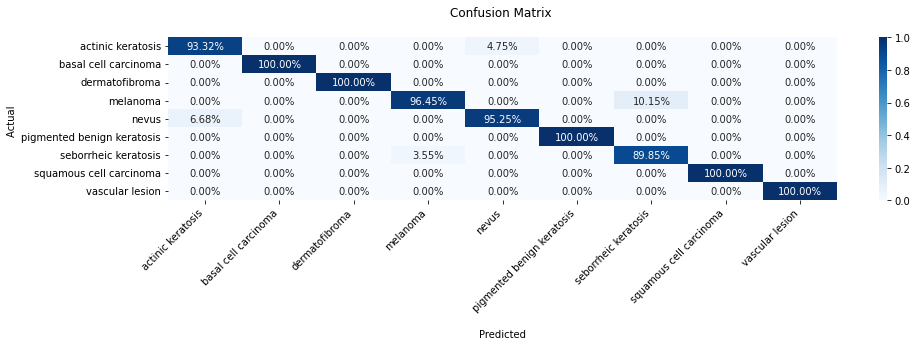

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['actinic keratosis','basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
ax.yaxis.set_ticklabels(['actinic keratosis','basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

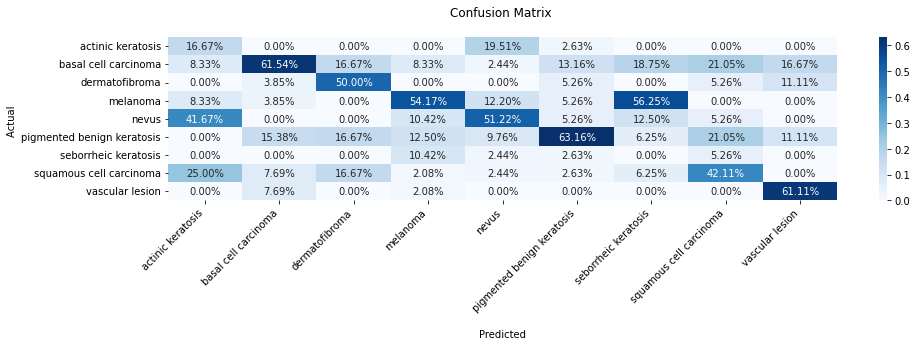

In [49]:
ax = sns.heatmap(cf_matrix2/np.sum(cf_matrix2, axis=0), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['actinic keratosis','basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
ax.yaxis.set_ticklabels(['actinic keratosis','basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

[Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'pigmented benign keratosis'),
 Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'vascular lesion')]

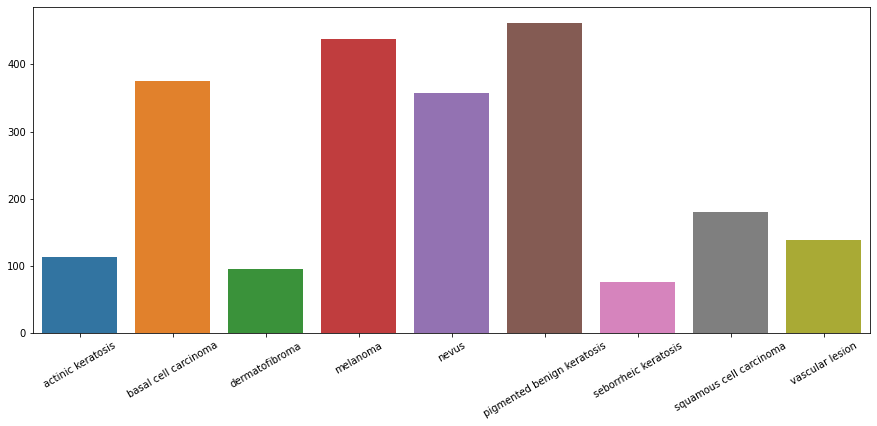

In [50]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)